# Imports

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# file management imports
import os  ### only for count of images from dir, can be removed later

# model imports for deep learning 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
import keras
from keras import optimizers
from keras.utils.np_utils import to_categorical

# image processing imports
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics
#for confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import itertools    


#for displaying images when predicting class
from PIL import Image, ImageOps
#for rounding up fitting model for steps_per_epoch
import math

from keras.models import load_model



Using TensorFlow backend.


# Loading data

In [2]:
#loading train and test datasets from directory ../shapes
train_dir = 'shapes/train'
test_dir = 'shapes/valid'



#Location of train and test sets of circle
train_dir_circle = train_dir+'/circle/JPEG'
test_dir_circle = test_dir+'/circle'
#Location of train and test sets of square
train_dir_square = train_dir+'/square/JPEG'
test_dir_square = test_dir+'/square'
#Location of train and test sets of triangle
train_dir_triangle = train_dir+'/triangle/JPEG'
test_dir_triangle = test_dir+'/triangle'
#Location of train and test sets of stars
train_dir_stars = train_dir+'/stars/JPEG'
test_dir_stars = test_dir+'/stars'

### i used a terminal command for spliting the stars dataset into train and test sets ### similar to this - %mv $(ls | sort -R | head -920) (directory)


# EDA

In [3]:
#checking the amount of images in each set
print('Total number of images in circle training set: ', len(os.listdir(train_dir_circle)))
print('Total number of images in circle test set:     ', len(os.listdir(test_dir_circle)))
print('Total number of images in square training set: ', len(os.listdir(train_dir_square)))
print('Total number of images in square test set:     ', len(os.listdir(test_dir_square)))
print('Total number of images in triangle training set:', len(os.listdir(train_dir_triangle)))
print('Total number of images in triangle test set:     ', len(os.listdir(test_dir_triangle)))
print('Total number of images in stars training set:', len(os.listdir(train_dir_stars)))
print('Total number of images in stars test set:     ', len(os.listdir(test_dir_stars)))

Total number of images in circle training set:  1008
Total number of images in circle test set:      114
Total number of images in square training set:  1012
Total number of images in square test set:      113
Total number of images in triangle training set: 1007
Total number of images in triangle test set:      113
Total number of images in stars training set: 1001
Total number of images in stars test set:      112


In [4]:
#checking the amount of images in each set
print('Total number of images in circle training set: ', len(os.listdir(train_dir_circle)))
print('Total number of images in circle test set:     ', len(os.listdir(test_dir_circle)))
print('Total number of images in square training set: ', len(os.listdir(train_dir_square)))
print('Total number of images in square test set:     ', len(os.listdir(test_dir_square)))
print('Total number of images in triangle training set:', len(os.listdir(train_dir_triangle)))
print('Total number of images in triangle test set:     ', len(os.listdir(test_dir_triangle)))
print('Total number of images in stars training set:', len(os.listdir(train_dir_stars)))
print('Total number of images in stars test set:     ', len(os.listdir(test_dir_stars)))

Total number of images in circle training set:  1008
Total number of images in circle test set:      114
Total number of images in square training set:  1012
Total number of images in square test set:      113
Total number of images in triangle training set: 1007
Total number of images in triangle test set:      113
Total number of images in stars training set: 1001
Total number of images in stars test set:      112


In [5]:
#display image smaller (for checking manually)
def display_image(image_directory):
    im = image.load_img(image_directory)
    fig, ax = plt.subplots(figsize=(10,6))
    # displaying the image with figsize
    ax.imshow(im)

Collage of sample images from circles and squares folders


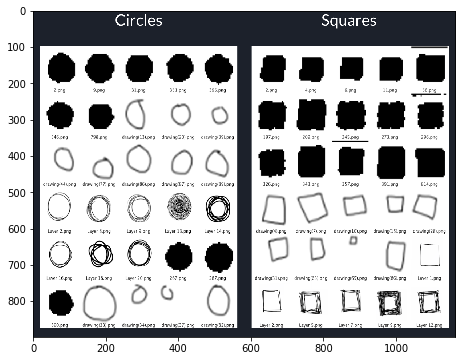

In [10]:
print('Collage of sample images from circles and squares folders')
display_image('readme_images/collage01.png')

Collage of sample images from triangles and stars folders


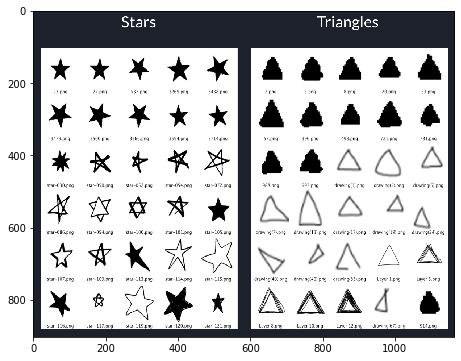

In [11]:
print('Collage of sample images from triangles and stars folders')
display_image('readme_images/collage02.png')

# Generator for Image Augmentation.

In [12]:
data_generator = ImageDataGenerator(        # Randomly augmentates, with effects below, through each image per epoch  
    
                                    rescale = 1.0/255.0,   # rescales image by multipling each pixel by this fraction
                                    fill_mode = 'nearest', # fills pixel at the edge to the nearest color (good for if the image is rotated or cropped weird)
                                    zoom_range = 0.2,      # can randomly apply a zoom to the image (from 0 to 20%)
                                    rotation_range = 45,   # can randomly apply a rotation to the image (from 0 to 45 degrees)
                                    shear_range = 0.05,    # can randomly add skew to the image had to add to help with angling of the photos
                                    horizontal_flip=True,  # can randomly flips the image on the x-axis
                                    vertical_flip=True,    # can randomly flips the image on the y-axis
                                    )

## Demoing the ImageDataGenerator on examples

In [23]:
import os 
from keras.preprocessing.image import ImageDataGenerator,  img_to_array, load_img
def generate_plot_pics(datagen,orig_img):
    dir_augmented_data = "ignore_files/images_for_presentation/preview"
    try:
        ## if the preview folder does not exist, create
        os.mkdir(dir_augmented_data)
    except:
        ## if the preview folder exists, then remove
        ## the contents (pictures) in the folder
        for item in os.listdir(dir_augmented_data):
            os.remove(dir_augmented_data + "/" + item)

    ## convert the original image to array
    x = img_to_array(orig_img)
    ## reshape (Sampke, Nrow, Ncol, 3) 3 = R, G or B
    x = x.reshape((1,) + x.shape)
    ## -------------------------- ##
    ## randomly generate pictures
    ## -------------------------- ##
    i = 0
    Nplot = 8
    for batch in datagen.flow(x,batch_size=1,
                          save_to_dir=dir_augmented_data,
                          save_prefix="pic",
                          save_format='jpeg'):
        i += 1
        if i > Nplot - 1: ## generate 8 pictures 
            break

    ## -------------------------- ##
    ##   plot the generated data
    ## -------------------------- ##
    fig = plt.figure(figsize=(8, 6))
    fig.subplots_adjust(hspace=0.02,wspace=0.01,
                    left=0,right=1,bottom=0, top=1)

    ## original picture
    ax = fig.add_subplot(3, 3, 1,xticks=[],yticks=[])        
    ax.imshow(orig_img)
    ax.set_title("original")

    i = 2
    for imgnm in os.listdir(dir_augmented_data):
        ax = fig.add_subplot(3, 3, i,xticks=[],yticks=[]) 
        img = load_img(dir_augmented_data + "/" + imgnm)
        ax.imshow(img)
        i += 1
    plt.show()

In [24]:
demo_generator = ImageDataGenerator(        
    
                                    rescale = 1.0/255.0,   
                                    fill_mode = 'nearest',
                                    zoom_range = [1-0.5, 1+0.2]  ,    
                                    rotation_range = 90,   
                                    shear_range = 1.2,  
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True,  
                                    vertical_flip=True,    
                                    )

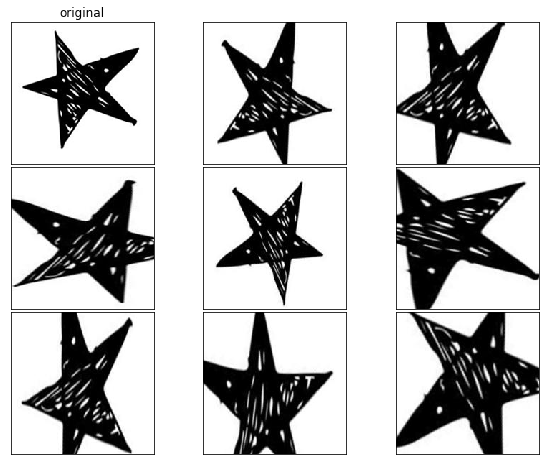

In [25]:
orig_img = load_img(test_dir_stars+"/star-005.png")
generate_plot_pics(demo_generator,orig_img)


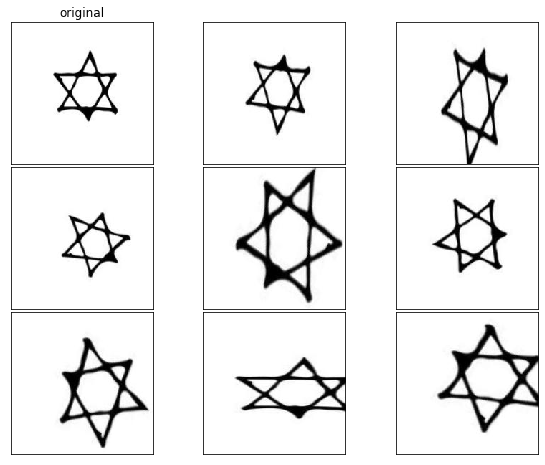

In [26]:
orig_img_02 = load_img("shapes/train/stars/star-036.png")
generate_plot_pics(demo_generator,orig_img_02)


# Fit generator to training and testing sets

In [27]:
# classes= ['Circle','Square','Triangle', 'Stars']
batch_size = 32

#making tensorflow for training data
training_data = data_generator.flow_from_directory(directory= train_dir,       # dataset
                                                   target_size = (64,64),      # desired dimensions for the images
                                                   batch_size = batch_size,    # it will be run in groups of(batch_size specified above)
                                                   class_mode = 'categorical', # type of classifiaction
                                                   shuffle=False)
#making tensorflow for testing data
testing_data = data_generator.flow_from_directory(directory= test_dir,
                                                   target_size = (64,64),
                                                   batch_size = batch_size,
                                                   class_mode = 'categorical',
                                                   shuffle=False)



Found 8056 images belonging to 4 classes.
Found 448 images belonging to 4 classes.


In [28]:
# preparing model for final layer in the Neural Net
num_classes = len(set(training_data.classes))
num_classes

4

# Building CNN model

In [37]:
model = Sequential()
    #first block
#first convolutional layer
model.add(Conv2D(filters = 8,          # first layer should have the lowest filter size
                 kernel_size = (4, 4),  # kernel_size = (3, 3) b/c image size smaller then 128x128
                 activation = 'relu',
                 padding="same",
                 input_shape = training_data.image_shape))  # first layer needs a input_shape (set it to size of training image)
#second convolutional layer
model.add(Conv2D(filters = 8, kernel_size = (3,3), padding="same",activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2)))  #divides 1 pixel into 4 (2x2)
model.add(Dropout(rate = 0.2))
    #second block
#third convolutional layer
model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding="same", activation = 'relu'))
#fourth convolutional layer
model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2)))
model.add(Dropout(rate = 0.2))
    #third block
#fifth convolutional layer
model.add(Conv2D(filters = 8, kernel_size = (3, 3), padding="same", activation = 'relu'))
#last convolutional layer (last layer should have the highest filter size)
model.add(Conv2D(filters = 8, kernel_size = (3, 3), padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2)))
model.add(Dropout(rate = 0.3))
# this converts our 3D feature maps to 1D feature vectors
model.add(Flatten())

model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.5))


#output layer
model.add(Dense(units = num_classes, activation = 'softmax'))
#optimizer for compiler
Adam=keras.optimizers.Adam(lr=0.01)

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy','mse'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 8)         392       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 16)       

# Fit model to training and testing sets

In [39]:
total_training_size = len(os.listdir(train_dir_circle))+len(os.listdir(train_dir_square))+len(os.listdir(train_dir_triangle))+len(os.listdir(train_dir_stars))
total_testing_size = len(os.listdir(test_dir_circle))+len(os.listdir(test_dir_square))+len(os.listdir(test_dir_triangle))+len(os.listdir(test_dir_stars))

print(f"Total # of images in training set: {total_training_size}")
print(f"Total # of images in testing set: {total_testing_size}")





Total # of images in training set: 4028
Total # of images in testing set: 452


In [40]:
#Trains the model on the data batch-by-batch (bit-by-bit)
fitted_model = model.fit_generator(training_data,
                                  steps_per_epoch = math.ceil(total_training_size//batch_size), # general rule: should be total datapoints divided by batch size ([2999/32] rounded up)
                                  epochs = 50,            
                                  validation_data = (testing_data),
                                  validation_steps = total_testing_size,
                                  max_queue_size = 10
                                  )

Epoch 1/50
125/125 [==============================] - 48s 385ms/step - loss: 1.3646 - accuracy: 0.2918 - mse: 0.1853 - val_loss: 1.0810 - val_accuracy: 0.4945 - val_mse: 0.1502
Epoch 2/50
125/125 [==============================] - 45s 363ms/step - loss: 1.0850 - accuracy: 0.4863 - mse: 0.1511 - val_loss: 0.9249 - val_accuracy: 0.4959 - val_mse: 0.1353
Epoch 3/50
125/125 [==============================] - 46s 365ms/step - loss: 0.9042 - accuracy: 0.5802 - mse: 0.1294 - val_loss: 0.8204 - val_accuracy: 0.5622 - val_mse: 0.1209
Epoch 4/50
125/125 [==============================] - 46s 365ms/step - loss: 0.8526 - accuracy: 0.5870 - mse: 0.1242 - val_loss: 0.7366 - val_accuracy: 0.6207 - val_mse: 0.1123
Epoch 5/50
125/125 [==============================] - 45s 363ms/step - loss: 0.7534 - accuracy: 0.6295 - mse: 0.1104 - val_loss: 0.6454 - val_accuracy: 0.6911 - val_mse: 0.0979
Epoch 6/50
125/125 [==============================] - 46s 364ms/step - loss: 0.7794 - accuracy: 0.6333 - mse: 0.114

125/125 [==============================] - 46s 367ms/step - loss: 0.1838 - accuracy: 0.9227 - mse: 0.0257 - val_loss: 0.1086 - val_accuracy: 0.9629 - val_mse: 0.0145
Epoch 48/50
125/125 [==============================] - 46s 367ms/step - loss: 0.2023 - accuracy: 0.9211 - mse: 0.0271 - val_loss: 0.1254 - val_accuracy: 0.9592 - val_mse: 0.0164
Epoch 49/50
125/125 [==============================] - 46s 368ms/step - loss: 0.2166 - accuracy: 0.9147 - mse: 0.0296 - val_loss: 0.1085 - val_accuracy: 0.9654 - val_mse: 0.0141
Epoch 50/50
125/125 [==============================] - 46s 369ms/step - loss: 0.1748 - accuracy: 0.9374 - mse: 0.0227 - val_loss: 0.0839 - val_accuracy: 0.9732 - val_mse: 0.0109


In [368]:
model.save('models/Final-MAIN-STARS_model_50_epochs_with_rescaler_zoom-0.2_rotation-45_skew-0.05_flip-hori_verti-02-main.h5')  # save your weights and model after training

In [41]:
# Trains the model on the data batch-by-batch (bit-by-bit) (@ 3times the epochs)
fitted_model_2 = model.fit_generator(training_data,
                                  steps_per_epoch = math.ceil((total_training_size//batch_size)*3), # general rule: should be total datapoints divided by batch size ([2999/32] rounded up)
                                  epochs = 100,            
                                  validation_data = (testing_data),
                                  validation_steps = total_testing_size,
                                  max_queue_size = 10
                                  )

Epoch 1/100
375/375 [==============================] - 80s 214ms/step - loss: 0.1961 - accuracy: 0.9278 - mse: 0.0258 - val_loss: 0.0822 - val_accuracy: 0.9723 - val_mse: 0.0108
Epoch 2/100
375/375 [==============================] - 79s 210ms/step - loss: 0.1920 - accuracy: 0.9272 - mse: 0.0252 - val_loss: 0.0863 - val_accuracy: 0.9756 - val_mse: 0.0109
Epoch 3/100
375/375 [==============================] - 78s 209ms/step - loss: 0.1695 - accuracy: 0.9400 - mse: 0.0221 - val_loss: 0.0993 - val_accuracy: 0.9674 - val_mse: 0.0127
Epoch 4/100
375/375 [==============================] - 79s 210ms/step - loss: 0.1769 - accuracy: 0.9349 - mse: 0.0237 - val_loss: 0.0758 - val_accuracy: 0.9764 - val_mse: 0.0094
Epoch 5/100
375/375 [==============================] - 79s 211ms/step - loss: 0.1674 - accuracy: 0.9385 - mse: 0.0218 - val_loss: 0.0804 - val_accuracy: 0.9745 - val_mse: 0.0101
Epoch 6/100
375/375 [==============================] - 80s 213ms/step - loss: 0.1709 - accuracy: 0.9385 - mse:

Epoch 47/100
375/375 [==============================] - 78s 209ms/step - loss: 0.1046 - accuracy: 0.9636 - mse: 0.0134 - val_loss: 0.0352 - val_accuracy: 0.9893 - val_mse: 0.0044
Epoch 48/100
375/375 [==============================] - 79s 210ms/step - loss: 0.1014 - accuracy: 0.9651 - mse: 0.0130 - val_loss: 0.0379 - val_accuracy: 0.9859 - val_mse: 0.0049
Epoch 49/100
375/375 [==============================] - 79s 210ms/step - loss: 0.1001 - accuracy: 0.9673 - mse: 0.0120 - val_loss: 0.0352 - val_accuracy: 0.9898 - val_mse: 0.0041
Epoch 50/100
375/375 [==============================] - 79s 212ms/step - loss: 0.1033 - accuracy: 0.9651 - mse: 0.0131 - val_loss: 0.0308 - val_accuracy: 0.9903 - val_mse: 0.0040
Epoch 51/100
375/375 [==============================] - 79s 210ms/step - loss: 0.0954 - accuracy: 0.9676 - mse: 0.0119 - val_loss: 0.0378 - val_accuracy: 0.9890 - val_mse: 0.0045
Epoch 52/100
375/375 [==============================] - 78s 208ms/step - loss: 0.0978 - accuracy: 0.9660 

Epoch 93/100
375/375 [==============================] - 79s 210ms/step - loss: 0.0887 - accuracy: 0.9710 - mse: 0.0110 - val_loss: 0.0319 - val_accuracy: 0.9904 - val_mse: 0.0036
Epoch 94/100
375/375 [==============================] - 79s 210ms/step - loss: 0.0847 - accuracy: 0.9710 - mse: 0.0107 - val_loss: 0.0266 - val_accuracy: 0.9898 - val_mse: 0.0036
Epoch 95/100
375/375 [==============================] - 79s 210ms/step - loss: 0.0821 - accuracy: 0.9704 - mse: 0.0106 - val_loss: 0.0281 - val_accuracy: 0.9913 - val_mse: 0.0034
Epoch 96/100
375/375 [==============================] - 79s 210ms/step - loss: 0.0921 - accuracy: 0.9700 - mse: 0.0113 - val_loss: 0.0316 - val_accuracy: 0.9915 - val_mse: 0.0037
Epoch 97/100
375/375 [==============================] - 80s 213ms/step - loss: 0.0857 - accuracy: 0.9726 - mse: 0.0103 - val_loss: 0.0282 - val_accuracy: 0.9925 - val_mse: 0.0032
Epoch 98/100
375/375 [==============================] - 78s 208ms/step - loss: 0.0773 - accuracy: 0.9758 

# Save model

In [42]:
model.save('models/Final-MAIN-STARS_model_cleaned-main.h5')  # save your weights and model after training

## Load model

In [101]:
# model = Sequential()
tf.keras.models.load_model('models/MAIN-STARS_model_50_epochs_with_rescaler_zoom-0.2_rotation-45_skew-0.02_flip-hori_verti-02-main.h5')

# Plotting metrics from model

In [43]:
last_10_acc=fitted_model.history['accuracy'][39:50]
all_acc = fitted_model.history['accuracy'][1:]
def avg(x):
    return sum(x)/len(x)
avg(last_10_acc)
# avg(all_acc)

0.9146535830064253

In [44]:
last_10_loss=fitted_model.history['loss'][39:50]
all_loss = fitted_model.history['loss'][1:]
# avg(all_loss)
avg(last_10_loss)

0.217349372551473

In [45]:
last_10_mse=fitted_model.history['mse'][39:50]
avg(last_10_mse)

0.029417047785087067

In [46]:
#getting and labeling the evaluations to plot
accuracy = fitted_model.history['accuracy'][1:]
loss = fitted_model.history['loss'][1:]
val_accuracy = fitted_model.history['val_accuracy'][1:]
val_loss = fitted_model.history['val_loss'][1:]
mse = fitted_model.history['mse'][1:]


In [48]:
last_10_acc_2=fitted_model_2.history['accuracy'][39:50]
all_acc_2 = fitted_model_2.history['accuracy'][1:]
last_10_loss_2 =fitted_model_2.history['loss'][39:50]
all_loss_2 = fitted_model_2.history['loss'][1:]
val_accuracy_2 = fitted_model_2.history['val_accuracy'][1:]
val_loss_2 = fitted_model_2.history['val_loss'][1:]
last_10_mse_2=fitted_model_2.history['mse'][39:50]
mse_2 = fitted_model_2.history['mse'][1:]
print(f'The averged last 10 accuracy scores: {avg(last_10_acc_2)}')
print(f'The averged of all accuracy scores: {avg(all_acc_2)}')
print(f'The averged last 10 loss values: {avg(last_10_loss_2)}')
print(f'The averged of all loss values: {avg(all_loss_2)}')
print(f'The averged of all cross validation accuracy scores: {avg(val_accuracy_2)}')
print(f'The averged of all cross validation loss values: {avg(val_loss_2)}')
print(f'The averged last 10 mse scores: {avg(last_10_mse_2)}')
print(f'The averged of all mse scores: {avg(mse_2)}')


The averged last 10 accuracy scores: 0.9642985788258639
The averged of all accuracy scores: 0.9624785889278759
The averged last 10 loss values: 0.10466310916403644
The averged of all loss values: 0.10842147208637692
The averged of all cross validation accuracy scores: 0.9868646336324287
The averged of all cross validation loss values: 0.04047717996743738
The averged last 10 mse scores: 0.01314384557984092
The averged of all mse scores: 0.013758458977922647


## Plot Accuracy vs Loss

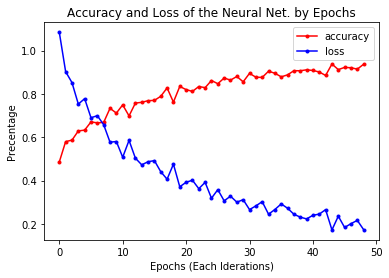

In [49]:
#plot accuracy for model
plt.plot(range(len(accuracy)), accuracy, 'r', marker= '.', label = 'accuracy')
#plot loss for model
plt.plot(range(len(loss)), loss, 'b', marker= '.', label = 'loss')
plt.xlabel('Epochs (Each Iderations)')
plt.ylabel('Precentage')
plt.title('Accuracy and Loss of the Neural Net. by Epochs')
plt.legend()

## Plot Cross Validation Accuracy vs Cross Validation Loss

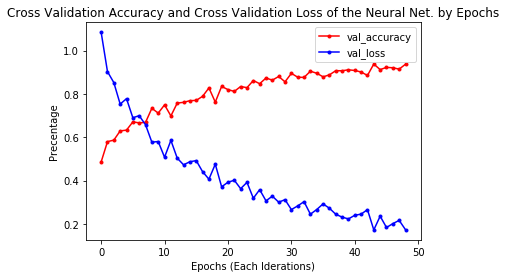

In [50]:
#plot cross validation accuracy for model
plt.plot(range(len(val_accuracy)), accuracy, 'r', marker= '.', label = 'val_accuracy')
#plot cross validation loss for model
plt.plot(range(len(val_loss)), loss, 'b', marker= '.', label = 'val_loss')
plt.xlabel('Epochs (Each Iderations)')
plt.ylabel('Precentage')
plt.title('Cross Validation Accuracy and Cross Validation Loss of the Neural Net. by Epochs')
plt.legend()

## Plot Mean Squared Error vs Loss

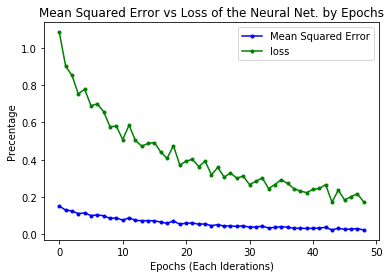

In [51]:
#plot mean squared error for model
plt.plot(range(len(mse)), mse, 'b', marker= '.', label = 'Mean Squared Error')
#plot accuracy for model
plt.plot(range(len(loss)), loss, 'g', marker= '.', label = 'loss')
plt.xlabel('Epochs (Each Iderations)')
plt.ylabel('Precentage')
plt.title('Mean Squared Error vs Loss of the Neural Net. by Epochs')
plt.legend()

## Plot Cross Validation Accuracy vs Mean Squared Error

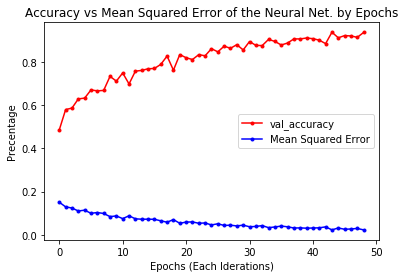

In [52]:
#plot cross validation accuracy for model
plt.plot(range(len(val_accuracy)), accuracy, 'r', marker= '.', label = 'val_accuracy')
#plot mean squared error for model
plt.plot(range(len(mse)), mse, 'b', marker= '.', label = 'Mean Squared Error')
plt.xlabel('Epochs (Each Iderations)')
plt.ylabel('Precentage')
plt.title('Accuracy vs Mean Squared Error of the Neural Net. by Epochs')
# plt.xticks(ticks=np.arange(2,25)
plt.legend()

# Confusion Matrix

In [53]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [54]:
test_set=test_dir_circle+test_dir_square+test_dir_triangle+test_dir_stars

In [55]:
# predicted_classes = np.argmax(predictions, axis=1)
true_classes = testing_data.classes
class_labels = list(testing_data.class_indices.keys()) 
print(class_labels)
print(true_classes)

['circle', 'square', 'stars', 'triangle']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3]


In [56]:
testing_data
predictions = model.predict_generator(testing_data)
predicted_classes = np.argmax(predictions, axis=1)


In [57]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

      circle       1.00      0.99      1.00       113
      square       0.99      1.00      1.00       112
       stars       1.00      1.00      1.00       111
    triangle       0.99      0.99      0.99       112

    accuracy                           1.00       448
   macro avg       1.00      1.00      1.00       448
weighted avg       1.00      1.00      1.00       448



In [58]:
pd.DataFrame(report)

ValueError: DataFrame constructor not properly called!

In [59]:
cm = metrics.confusion_matrix(true_classes, predicted_classes)

Confusion Matrix, without normalization
[[112   0   0   1]
 [  0 112   0   0]
 [  0   0 111   0]
 [  0   1   0 111]]


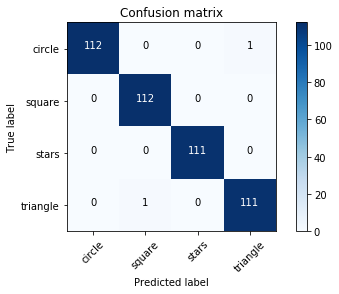

In [60]:
plot_confusion_matrix(cm,class_labels)

# testing the model

In [61]:
#checking the labels for the classification 
train_labels = training_data.classes
train_labels = to_categorical(train_labels,num_classes)
# validation_labels = training_data.classes
# validation_labels = to_categorical(validation_labels,num_classes)
train_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [62]:
#function for predicting category of slected image
def testing_image(image_directory):

#     predicted_classes=
    
    # loading testing image with the target size for the image
    test_image = image.load_img(image_directory, target_size = (64,64))
    # makes sure the image is in RGB (converts all images to have only 3 color channels, png images have 4 color channels)
    test_image = test_image.convert(mode='RGB')
    # converts image into an array
    test_image = tf.keras.preprocessing.image.img_to_array(test_image)
    # expands array (from converted image) with a new dimension (for classifying values)
    test_image = np.expand_dims(test_image, axis = 0)
    test_image = tf.keras.applications.inception_v3.preprocess_input(test_image)
    # making prediction based on test_image and labeling it results
    result = model.predict(x = test_image)
    # printing predictions
    print(result)
    
    #display image smaller (for checking manually)
    display_image(image_directory)

    # computing category weither a shape is a rectangle, square, star or triangle
    if result[0][0] > result[0][1] + result[0][2] + result[0][3]:
        print(f'Shape is predicted as a Circle with {"%.1f" % ((result[0][0])*100)}% certainty')
    elif result[0][1] > result[0][0] + result[0][2] + result[0][3]:
        print(f'Shape is predicted as a Square with {"%.1f" % ((result[0][1])*100)}% certainty')
    elif result[0][2] > result[0][0] + result[0][1] + result[0][3]:
        print(f'Shape is predicted as a Star with {"%.1f" % ((result[0][2])*100)}% certainty')
    elif result[0][3] > result[0][0] + result[0][1] + result[0][2]:
        print(f'Shape is predicted as a Triangle with {"%.1f" % ((result[0][3])*100)}% certainty')



## Testing images grabbed online or drawn by hand

[[1.0000000e+00 7.0455013e-29 0.0000000e+00 0.0000000e+00]]
Shape is predicted as a Circle with 100.0% certainty


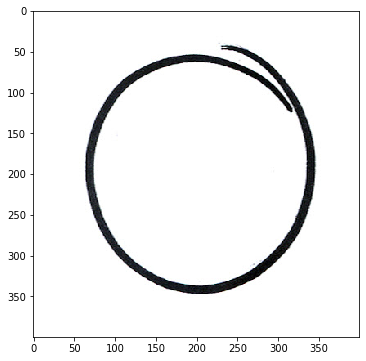

In [63]:
# print test image classified category
testing_image('images_to_predict/drawn_circle1.jpg')

[[9.9999964e-01 3.1810950e-07 0.0000000e+00 7.8494126e-17]]
Shape is predicted as a Circle with 100.0% certainty


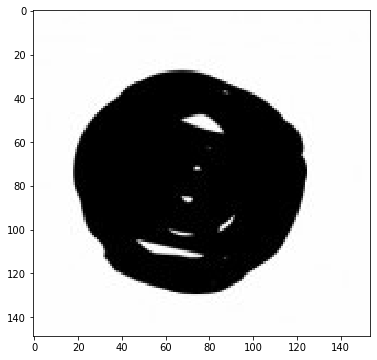

In [64]:
# print test image classified category
testing_image('images_to_predict/1_dot.png')

[[0. 0. 0. 1.]]
Shape is predicted as a Triangle with 100.0% certainty


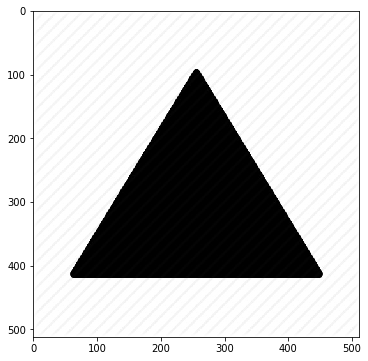

In [65]:
# print test image classified category
testing_image('images_to_predict/Triangle-3_-_Basic_UI_Glyph_Black-5-512.jpg')

[[0. 0. 0. 1.]]
Shape is predicted as a Triangle with 100.0% certainty


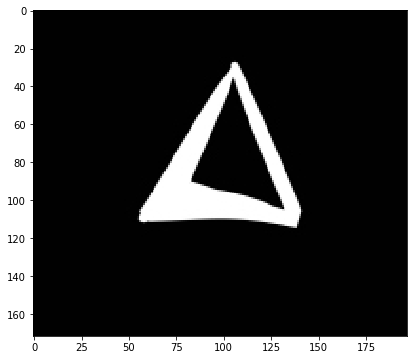

In [66]:
# print test image classified category
testing_image('images_to_predict/seamless-hand-drawn-triangle-pattern-with-black-and-white-png_75455.jpg')

[[1.2789351e-04 9.9987209e-01 0.0000000e+00 8.5290966e-16]]
Shape is predicted as a Square with 100.0% certainty


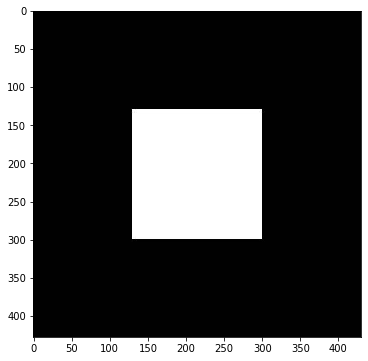

In [67]:
# print test image classified category
testing_image('images_to_predict/square-oq9l82oaujo11-01.jpg')

[[0.31700468 0.46468025 0.0016651  0.21664998]]


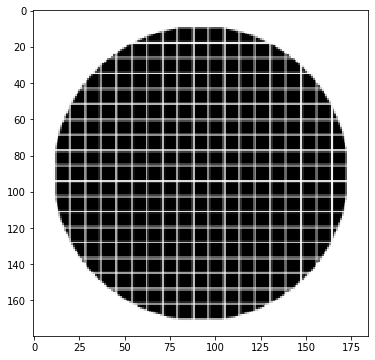

In [68]:
# print test image classified category
testing_image('images_to_predict/01_Circles_made_of_squares.png')


[[0.01999194 0.13418561 0.5948469  0.25097555]]
Shape is predicted as a Star with 59.5% certainty


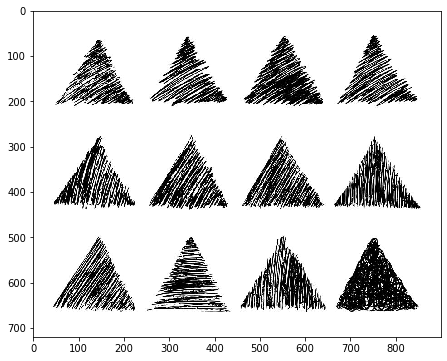

In [85]:
# print test image classified category
testing_image('images_to_predict/hand-drawn-pencil-scribble-triangles-andrii-shelenkov.jpg')

[[6.32218973e-17 1.16836375e-17 1.49823189e-22 1.00000000e+00]]
Shape is predicted as a Triangle with 100.0% certainty


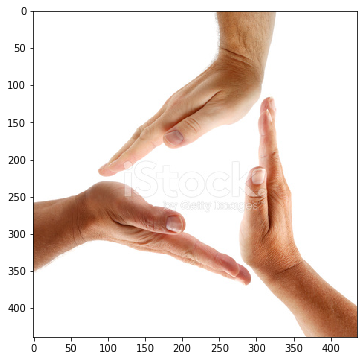

In [70]:
# print test image classified category
testing_image('images_to_predict/21063418-hands-in-triangle-shape.jpg')


[[1.1207996e-11 2.5335833e-14 1.3454808e-18 1.0000000e+00]]
Shape is predicted as a Triangle with 100.0% certainty


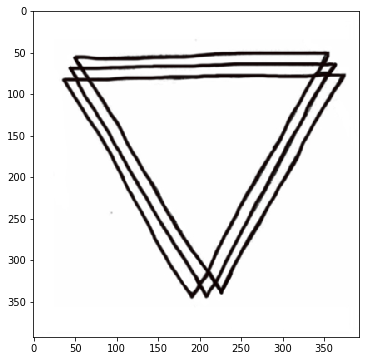

In [71]:
# print test image classified category
testing_image('images_to_predict/hand_drawn_prism.jpg')


[[0.31700468 0.46468025 0.0016651  0.21664998]]


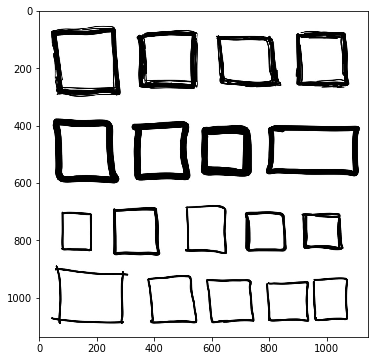

In [72]:
# print test image classified category
testing_image('images_to_predict/hand_drawn_squares.jpg')


[[0.31700468 0.46468025 0.0016651  0.21664998]]
This image is predicted as a square because the circle are forming a square shape


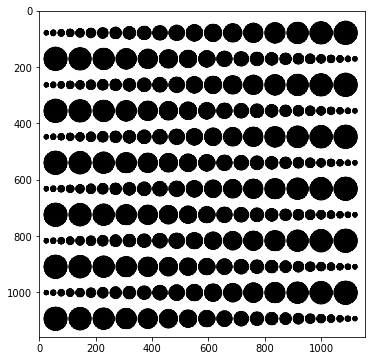

In [73]:
# print test image classified category
testing_image('images_to_predict/Screen Shot 2020-01-11 at 10.29.46 AM.png')

This image is predicted mostly as a square (46%) because the circle are forming a square shape, a circle a close second(31%)

[[3.53272540e-14 1.24126185e-08 9.99999404e-01 6.11266898e-07]]
Shape is predicted as a Star with 100.0% certainty


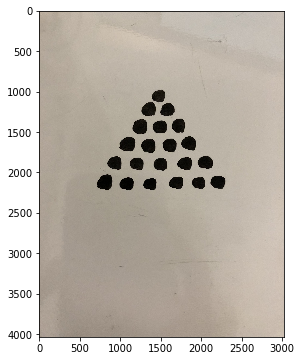

In [86]:
# print test image classified category
testing_image('images_to_predict/IMG_5265.jpg')


[[1.2275717e-19 5.9426752e-12 5.2768474e-25 1.0000000e+00]]
Shape is predicted as a Triangle with 100.0% certainty


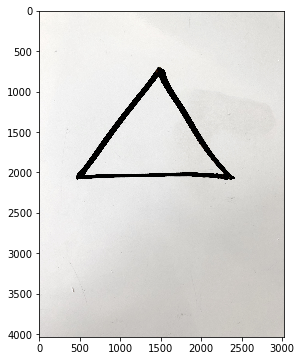

In [87]:
# print test image classified category
testing_image('images_to_predict/IMG_5257.jpg')


[[3.5667532e-07 4.9897698e-03 8.0082180e-10 9.9500990e-01]]
Shape is predicted as a Triangle with 99.5% certainty


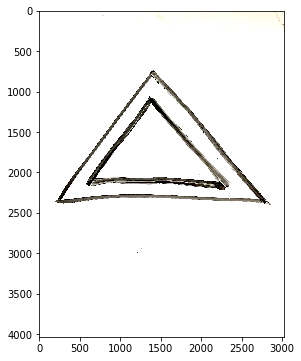

In [88]:
# print test image classified category
testing_image('images_to_predict/IMG_5254.jpg')


[[3.4915265e-05 1.4445516e-02 1.5125652e-04 9.8536831e-01]]
Shape is predicted as a Triangle with 98.5% certainty


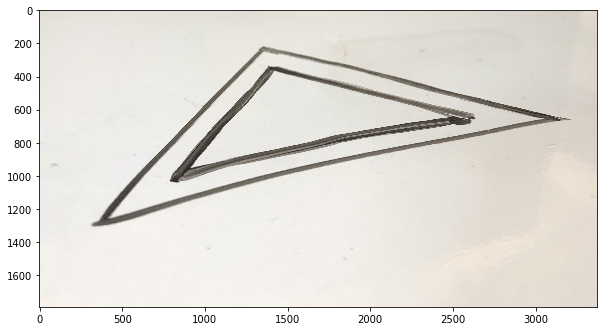

In [89]:
# print test image classified category
testing_image('images_to_predict/IMG_5255.jpg')


[[7.1414236e-10 1.2893127e-09 4.0289774e-07 9.9999964e-01]]
Shape is predicted as a Triangle with 100.0% certainty


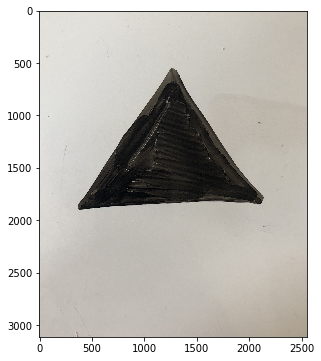

In [90]:
# print test image classified category
testing_image('images_to_predict/IMG_5258.jpg')


[[8.721204e-20 9.999999e-01 0.000000e+00 8.977357e-08]]
Shape is predicted as a Square with 100.0% certainty


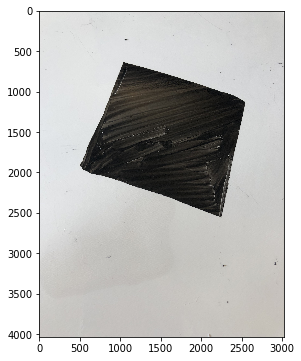

In [91]:
# print test image classified category
testing_image('images_to_predict/IMG_5259.jpg')


[[1.9279396e-08 9.9999988e-01 5.6180026e-35 8.7443105e-08]]
Shape is predicted as a Square with 100.0% certainty


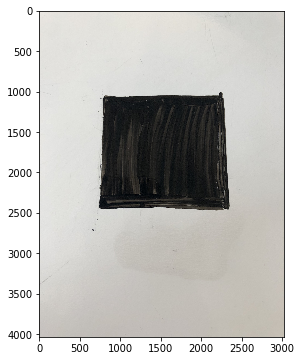

In [92]:
# print test image classified category
testing_image('images_to_predict/IMG_5260.jpg')


[[9.8548943e-01 1.4331588e-02 1.3508941e-12 1.7903476e-04]]
Shape is predicted as a Circle with 98.5% certainty


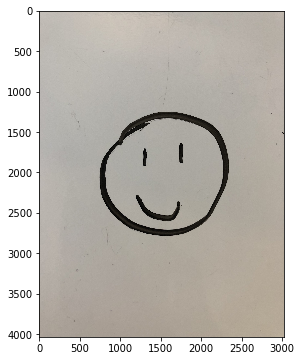

In [93]:
# print test image classified category
testing_image('images_to_predict/IMG_5261.jpg')


[[5.9372995e-10 1.0000000e+00 1.3162934e-35 6.6581824e-09]]
Shape is predicted as a Square with 100.0% certainty


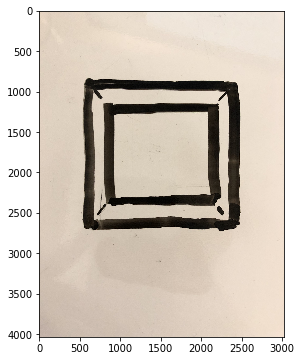

In [94]:
# print test image classified category
testing_image('images_to_predict/IMG_5264.jpg')


[[0. 0. 1. 0.]]
Shape is predicted as a Star with 100.0% certainty


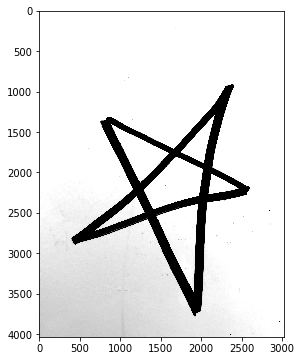

In [95]:
testing_image('images_to_predict/IMG_5269.jpg')


[[0.0000000e+00 9.2203190e-36 1.0000000e+00 3.1274512e-27]]
Shape is predicted as a Star with 100.0% certainty


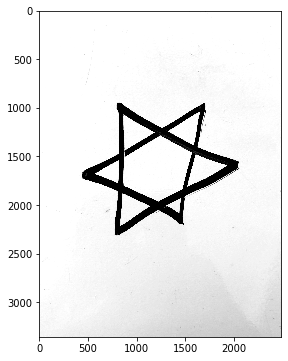

In [96]:
testing_image('images_to_predict/IMG_5268.jpg')
